In [1]:
from dof_trt_engine import DoFEngine, SixDofEnd2End
from dof_trt_utils import draw_axis, compute_euler_angles_from_rotation_matrices, compute_rotation_matrix_from_ortho6d
import numpy as np
import cv2
import time
import os, sys
import argparse
from loguru import logger
import matplotlib.pyplot as plt

logger.add('./end2end.log')
yolo_path = './end2end_onnx_2.trt'
dof_path = './sixdresnet.trt'

end2end = SixDofEnd2End(yolo_path, dof_path, logger=logger)

/opt/conda/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-04-20 05:05:23.603 | INFO     | dof_trt_engine:__init__:32 - starting YOLO engine yolo
2023-04-20 05:05:23.845 | INFO     | dof_trt_engine:__init__:52 - 
 output size : 30 
 dtype : <class 'numpy.int32'> 
 input_size : (640, 640) 
 
2023-04-20 05:05:23.846 | INFO     | dof_trt_engine:__init__:53 - Finish load YOLO engine ./end2end_onnx_2.trt
2023-04-20 05:05:23.848 | INFO     | dof_trt_engine:__init__:152 - Starting DoF engine : ./sixdresnet.trt
2023-04-20 05:05:23.886 | INFO     | dof_trt_engine:__init__:175 - 
 output size : 6 
 dtype : <class 'numpy.float32'> 
 input_size : (112, 112) 
 
2023-04-20 05:05:23.887 | INFO     | dof_trt_engine:__init__:176 - Finish load DoF engine ./sixdresnet.trt


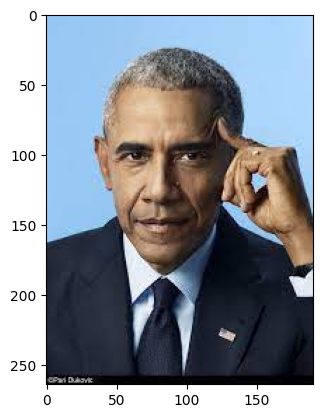

In [2]:
ori_img = cv2.imread('./obama.jpg')
img = ori_img[:,:,::-1]
plt.imshow(img)

In [3]:
preprocess_img = end2end.yolo_img_preprocess(ori_img)

(3, 640, 640)


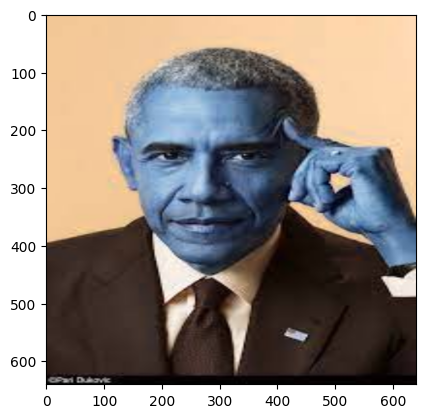

In [4]:
print(preprocess_img.shape)
plt.imshow(preprocess_img.transpose(1,2,0))

dof prediction :  [[ 7.2773438   0.27539062 -0.35986328  0.45751953  5.2539062  -0.5996094 ]]
dof prediction :  [[ 7.2773438   0.27539062 -0.35986328  0.45751953  5.2539062  -0.5996094 ]]


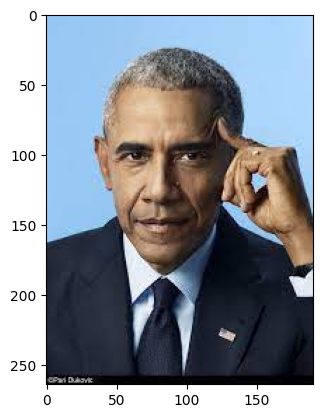

In [5]:
plt.imshow(img)
output = end2end.forward(img)
print("dof prediction :  [[ 7.2773438   0.27539062 -0.35986328  0.45751953  5.2539062  -0.5996094 ]]")

In [6]:
print(output)

(array([[[0.5882353 , 0.5882353 , 0.5882353 , ..., 0.72156864,
         0.7254902 , 0.7254902 ],
        [0.5882353 , 0.5882353 , 0.5882353 , ..., 0.72156864,
         0.7254902 , 0.7254902 ],
        [0.5882353 , 0.5882353 , 0.5882353 , ..., 0.72156864,
         0.7254902 , 0.7254902 ],
        ...,
        [0.05098039, 0.05098039, 0.05098039, ..., 0.01960784,
         0.01960784, 0.01960784],
        [0.01960784, 0.01960784, 0.02352941, ..., 0.00784314,
         0.00784314, 0.00784314],
        [0.01176471, 0.01176471, 0.01176471, ..., 0.00392157,
         0.00392157, 0.00392157]],

       [[0.78039217, 0.78039217, 0.78039217, ..., 0.85882354,
         0.85882354, 0.85882354],
        [0.78039217, 0.78039217, 0.78039217, ..., 0.85882354,
         0.85882354, 0.85882354],
        [0.78039217, 0.78039217, 0.78039217, ..., 0.85882354,
         0.85882354, 0.85882354],
        ...,
        [0.05098039, 0.05098039, 0.05098039, ..., 0.01568628,
         0.01568628, 0.01568628],
        [0.

<class 'numpy.ndarray'>


True

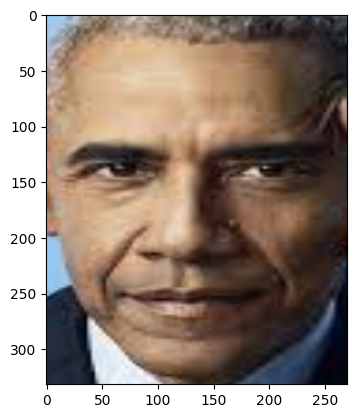

In [7]:
face = output[4]
int_face = np.ascontiguousarray(face * 255, dtype=np.uint8)
plt.imshow(int_face)
print(type(int_face))
cv2.imwrite('obama_face.png', int_face[:,:,::-1])

In [8]:
preproc_face = end2end.dof_model.preprocess(face)

In [9]:
output = end2end.dof_model.infer(preproc_face)

In [10]:
print(output)

[array([ 7.2773438 ,  0.27539062, -0.35986328,  0.45751953,  5.2539062 ,
       -0.5996094 ], dtype=float32)]


In [11]:
output2 = np.array([5.6367188,  0.41479492, -0.06890869,  0.25048828,  4.4453125,  -0.37329102], dtype=np.float32)
out1 = end2end.dof_model.postprocess(output[0].reshape(1, -1))
out2 = end2end.dof_model.postprocess(output2.reshape(1, -1))
output_rotate_matrix = compute_rotation_matrix_from_ortho6d(output2.reshape(1,-1)) 
print(output_rotate_matrix)
euler = compute_euler_angles_from_rotation_matrices(output_rotate_matrix)*180/np.pi
print(euler)
pitch, yaw, roll = euler[:, 0], euler[:, 1], euler[:, 2]
print(pitch, yaw, roll)
print(out1)
print(out2)

[[[ 0.9972293  -0.07414348  0.00604942]
  [ 0.07338412  0.99381554  0.08333953]
  [-0.01219109 -0.08266469  0.9965028 ]]]
[[-4.74210216  0.69851544  4.2086964 ]]
[-4.74210216] [0.69851544] [4.2086964]
(array([-6.17878506]), array([2.82893757]), array([2.16716353]))
(array([-4.74210216]), array([0.69851544]), array([4.2086964]))


In [12]:
output = end2end.forward(img)

dof prediction :  [[ 7.2773438   0.27539062 -0.35986328  0.45751953  5.2539062  -0.5996094 ]]


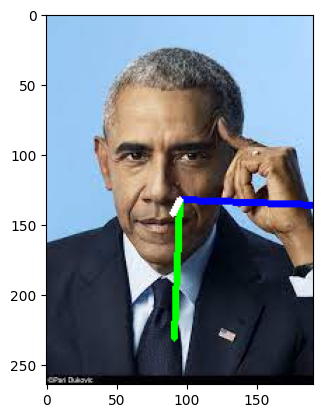

In [13]:
int_img = np.array(img, dtype=np.uint8) 

out_img = draw_axis(int_img, output[-2], output[-3], output[-1])
plt.imshow(out_img)